# 1. 문제 정의

* **Bank Marketing Dataset**<br>

  

* **데이터셋 출처**
  https://www.kaggle.com/janiobachmann/bank-marketing-campaign-opening-a-term-deposit

  

* **문제 정의**<br>
  고객 정보, 과거 마케팅 히스토리 등의 데이터 셋을 분석하여 고객이 텔레마케팅을 통해 신규 상품에 가입할지 아닐지 여부를 예측합니다. 가입 여부(True/False)를 판단하는 문제이므로 이진분류 문제로 정의할 수 있습니다. '분류'문제를 해결하기 위한 Classifier를 모델로 설정하고, 모델 평가는 Accuracy를 사용할 수 있습니다. 

라이브러리 임포트

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf

# 2. 데이터 전처리


데이터 전처리를 진행합니다. 원본 데이터를 로딩하고,  다음 과정을 수행합니다.

* EDA
* 결측치처리
* 이상치처리: EDA를 통해 이상치 여부를 확인하고, 이상치 데이터를 제거 또는 변환합니다.
* 텍스트처리: 텍스트는 숫자로 변환합니다.
* Categorical 데이터: 필드의 타입을 구분하기 위해 사용한 Categorical 데이터는 크기가 없는 숫자인 One-hot 형태로 변환합니다.
* X-Y 데이터 분할: 독립변수 X와 종속변수 Y로 데이터를 분할합니다.
* Train-Test 분할: 학습용 데이터셋과 테스트용 데이터셋으로 분할합니다. 학습용 데이터셋은 모델 학습(fit())시 사용하고, 테스트용 데이터셋은 모델 평가(predict() 후 accuracy 측정)에 사용합니다.

In [2]:
df = pd.read_csv('./dataset/bank.csv')

## (1) EDA

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [4]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


### 독립변수 탐색
#### object 타입 객체의 종류(unique)  확인

object 타입의 객체 종류가 2개인지, 3개 이상인지 확인합니다.<br>
2개의 경우는 1, 0으로 수치 변환하고, 3개 이상인 경우에는 one-hot으로 변환합니다.

In [5]:
for col in df.columns:
    if df[col].dtypes == object:
        print("{0}의 종류:{1}".format(col, df[col].unique()))

job의 종류:['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed'
 'student']
marital의 종류:['married' 'single' 'divorced']
education의 종류:['secondary' 'tertiary' 'primary' 'unknown']
default의 종류:['no' 'yes']
housing의 종류:['yes' 'no']
loan의 종류:['no' 'yes']
contact의 종류:['unknown' 'cellular' 'telephone']
month의 종류:['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
poutcome의 종류:['unknown' 'other' 'failure' 'success']
deposit의 종류:['yes' 'no']


#### 직업군(job) 별 응답수

In [6]:
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

#### 직업군(job) 별 응답수 시각화

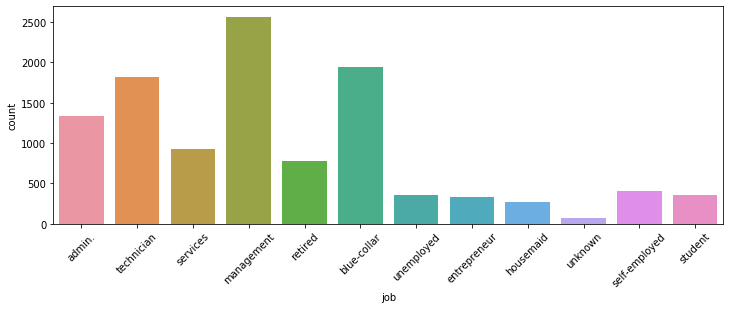

In [7]:
plt.subplots(figsize=(12,4))
plt.xticks(rotation = 45 )
sns.countplot(df['job'])

#### 직업군(job) 별 마케팅 성공 여부 시각화

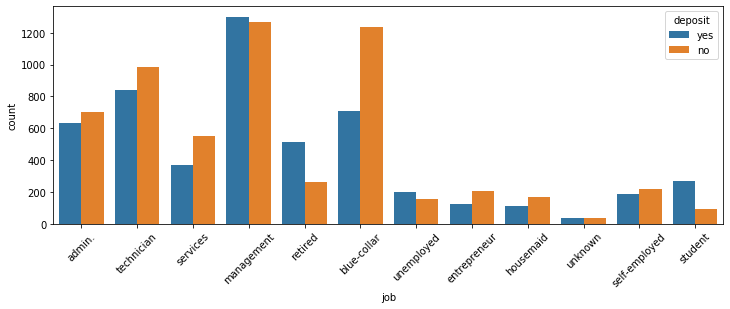

In [8]:
plt.subplots(figsize=(12,4))
plt.xticks(rotation = 45 )
sns.countplot(df['job'], hue=df['deposit'])

'blue-collar', 'services' 직종은 정기 예금에 가입 할 가능성이 적습니다.

#### 연령별(age) 응답수 시각화

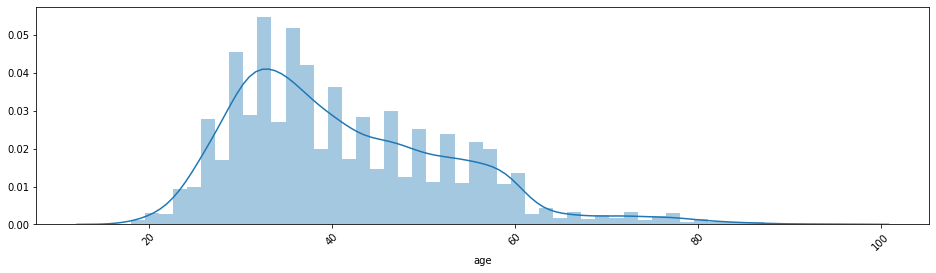

In [9]:
plt.subplots(figsize=(16,4))
plt.xticks(rotation = 45)
# sns.countplot(df['age'])
sns.distplot(df['age'])

In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['deposit_num'] = le.fit_transform(df['deposit'])

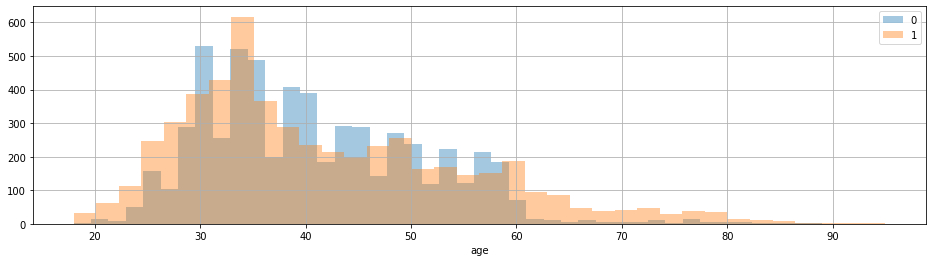

In [11]:
plt.subplots(figsize=(16,4))
plt.grid()
sns.distplot(df[df['deposit_num']== 0]['age'], kde=False)
sns.distplot(df[df['deposit_num']== 1]['age'], kde=False)
plt.legend(['0','1'])

#### object 타입의 데이터에 대한 응답수 시각화
education, default, housing, loan, contact, month, poutcome, marital

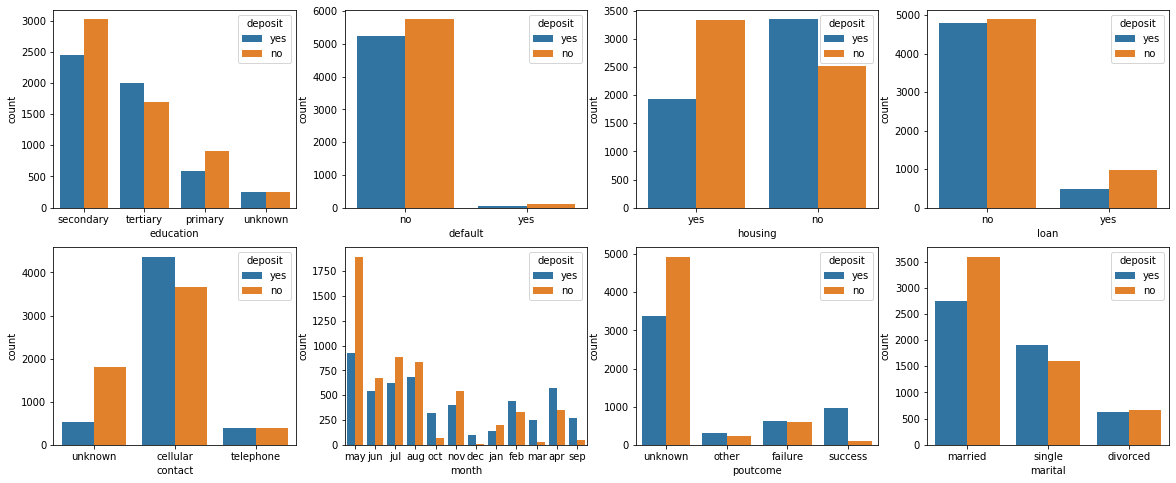

In [12]:
figure, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))
sns.countplot(df['education'], hue=df['deposit'], ax=ax1)
sns.countplot(df['default'], hue=df['deposit'], ax=ax2)
sns.countplot(df['housing'], hue=df['deposit'], ax=ax3)
sns.countplot(df['loan'], hue=df['deposit'], ax=ax4)
sns.countplot(df['contact'], hue=df['deposit'], ax=ax5)
sns.countplot(df['month'], hue=df['deposit'], ax=ax6)
sns.countplot(df['poutcome'], hue=df['deposit'], ax=ax7)
sns.countplot(df['marital'], hue=df['deposit'], ax=ax8)

1. education이 'primary', 'secondary'의 경우 정기 예금을 신청할 가능성이 적습니다.
2. 'housing' 고객(housing loan 보유)은 정기 예금을 신청할 가능성이 적습니다.
3. 'may'에는 정기 예금을 신청할 가능성이 적습니다.
4. 'married' 고객은 정기 예금을 신청할 가능성이 적습니다.

#### 수치형 타입의 데이터에 대한 응답수 시각화
balance,day,duration,campaign, pdays, previous

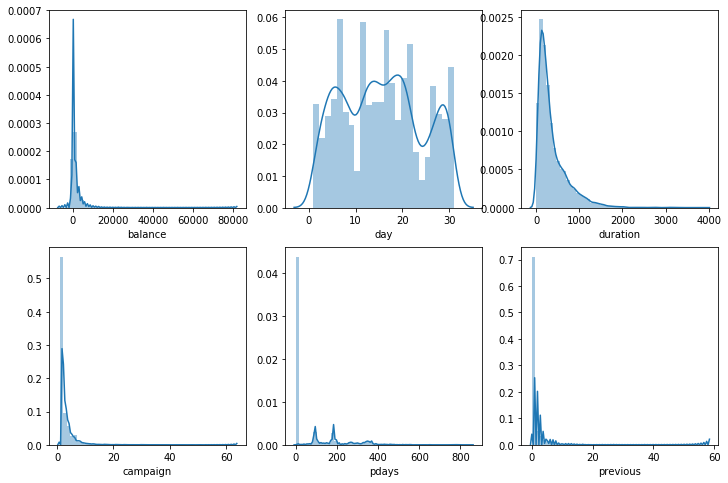

In [13]:
figure, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
sns.distplot(df['balance'], ax=ax1)
sns.distplot(df['day'], ax=ax2)
sns.distplot(df['duration'], ax=ax3)
sns.distplot(df['campaign'], ax=ax4)
sns.distplot(df['pdays'], ax=ax5)
sns.distplot(df['previous'], ax=ax6)

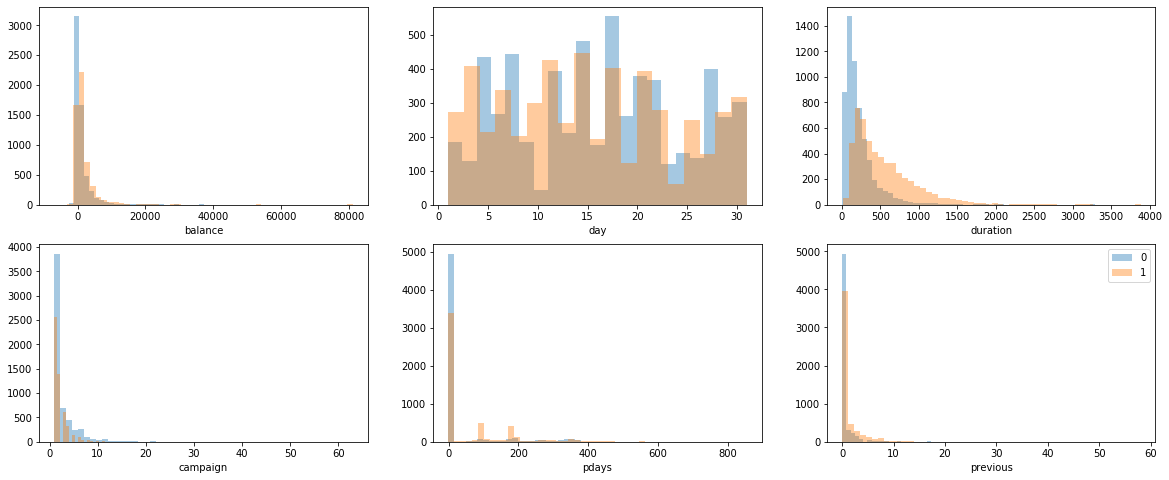

In [14]:
figure, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(20, 8))
sns.distplot(df[df['deposit_num']== 0]['balance'], kde=False, ax=ax1)
sns.distplot(df[df['deposit_num']== 1]['balance'], kde=False, ax=ax1)
sns.distplot(df[df['deposit_num']== 0]['day'], kde=False, ax=ax2)
sns.distplot(df[df['deposit_num']== 1]['day'], kde=False, ax=ax2)
sns.distplot(df[df['deposit_num']== 0]['duration'], kde=False, ax=ax3)
sns.distplot(df[df['deposit_num']== 1]['duration'], kde=False, ax=ax3)
sns.distplot(df[df['deposit_num']== 0]['campaign'], kde=False, ax=ax4)
sns.distplot(df[df['deposit_num']== 1]['campaign'], kde=False, ax=ax4)
sns.distplot(df[df['deposit_num']== 0]['pdays'], kde=False, ax=ax5)
sns.distplot(df[df['deposit_num']== 1]['pdays'], kde=False, ax=ax5)
sns.distplot(df[df['deposit_num']== 0]['previous'], kde=False, ax=ax6)
sns.distplot(df[df['deposit_num']== 1]['previous'], kde=False, ax=ax6)
plt.legend(['0','1'])

1. 정기 예금을 신청 한 사람들은 balance와 age가 더 높은 경향이 있습니다.
2. 정기 예금을 신청 한 사람들은이 campaign(캠패인 기간 중 고객 연락)의 수가 적은 경향이 있습니다.

In [15]:
grouped = df['balance'].groupby(df['deposit'])

print('[balance min]')
print(grouped.min())
print('\n[balance mean]')
print(grouped.mean())
print('\n[balance max]')
print(grouped.max())

[balance min]
deposit
no    -6847
yes   -3058
Name: balance, dtype: int64

[balance mean]
deposit
no     1280.227141
yes    1804.267915
Name: balance, dtype: float64

[balance max]
deposit
no     66653
yes    81204
Name: balance, dtype: int64


In [16]:
grouped = df['duration'].groupby(df['deposit'])

print('[duration min]')
print(grouped.min())
print('\n[duration mean]')
print(grouped.mean())
print('\n[duration max]')
print(grouped.max())

[duration min]
deposit
no     2
yes    8
Name: duration, dtype: int64

[duration mean]
deposit
no     223.130257
yes    537.294574
Name: duration, dtype: float64

[duration max]
deposit
no     3284
yes    3881
Name: duration, dtype: int64


### 종속변수(deposit) 탐색

#### 마케팅 결과(deposit) 

In [17]:
value_counts = df['deposit'].value_counts()
value_counts

no     5873
yes    5289
Name: deposit, dtype: int64

#### 마케팅 결과(deposit) 시각화

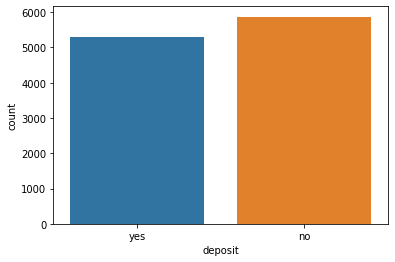

In [18]:
sns.countplot(df['deposit'])

'yes'와 'no'의 응답수가 거의 비슷한 분포를 보이므로, accuracy를 평가 지표로 활용

## (2) 결측치 확인

In [19]:
df.isnull().sum()

age            0
job            0
marital        0
education      0
default        0
balance        0
housing        0
loan           0
contact        0
day            0
month          0
duration       0
campaign       0
pdays          0
previous       0
poutcome       0
deposit        0
deposit_num    0
dtype: int64

## (3) 이상치처리

이상치 발생 가능성이 있어보이는 항목('campaign','pdays', 'previous') 확인

In [20]:
df[['campaign','pdays', 'previous']].describe()

,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000
mean,2.508421,51.330407,0.832557
std,2.722077,108.758282,2.292007
min,1.000000,-1.000000,0.000000
25%,1.000000,-1.000000,0.000000
50%,2.000000,-1.000000,0.000000
75%,3.000000,20.750000,1.000000
max,63.000000,854.000000,58.000000


#### 이상치 제거(campain)

'campain'에서 20이상의 값 비율

In [21]:
total_len = len(df)
campain_anomaly_len = len (df[df['campaign'] > 20] )
print("전체 {0}개 데이터 중 20을 넘는 campain 값은 {1}개, {2:.2f}%"
      .format(total_len, campain_anomaly_len, campain_anomaly_len/total_len*100))

전체 11162개 데이터 중 20을 넘는 campain 값은 42개, 0.38%


[TODO] 'campain'에서 20이상의 값에 대해 이상치 처리

#### 이상치 제거(pdays)
'pdays'에서 400 이상의 값

In [22]:
pdays_anomaly_len = len(df[df['pdays'] > 400] )
pdays_na_len = len(df[df['pdays'] == -1] )
print("전체 {0}개 데이터 중 400을 넘는 pdays 값은 {1}개, {2:.2f}%"
      .format(total_len, pdays_anomaly_len, pdays_anomaly_len/total_len*100))
print("전체 {0}개 데이터 중 -1인 pdays 값은 {1}개, {2:.2f}%"
      .format(total_len, pdays_na_len, pdays_na_len/total_len*100))

전체 11162개 데이터 중 400을 넘는 pdays 값은 134개, 1.20%
전체 11162개 데이터 중 -1인 pdays 값은 8324개, 74.57%


[TODO] 'pdays'에서 400이상의 값에 대해 이상치 처리<br>
[TODO] 'pdays'에서 -1인 값에 대해 이상치 처리

#### 이상치 제거(previous)
'previous'에서 20 이상의 값

In [23]:
previous_anomaly_len = len(df[df['previous'] > 20] )
print("전체 {0}개 데이터 중 400을 넘는 previous 값은 {1}개, {2:.2f}%"
      .format(total_len, previous_anomaly_len, previous_anomaly_len/total_len*100))

전체 11162개 데이터 중 400을 넘는 previous 값은 15개, 0.13%


[TODO]'previous'에서 20이상인 값에 대해 이상치 처리

In [24]:
# [TODO] 'campain'에서 20이상의 값에 대해 이상치 처리
df['campaign'] = df['campaign'].apply(lambda x: np.nan if x > 20 else x)

In [25]:
# [TODO] 'pdays'에서 400이상의 값에 대해 이상치 처리
# [TODO] 'pdays'에서 -1인 값에 대해 이상치 처리
# df['pdays'] = df['pdays'].apply(lambda x: np.nan if x > 400 or x == -1  else x)
df['pdays'] = df['pdays'].apply(lambda x: np.nan if x > 400  else x)

In [26]:
# [TODO]'previous'에서 20이상인 값에 대해 이상치 처리
df['previous'] = df['previous'].apply(lambda x: np.nan if x > 20 else x)

In [27]:
df.isnull().sum()

age              0
job              0
marital          0
education        0
default          0
balance          0
housing          0
loan             0
contact          0
day              0
month            0
duration         0
campaign        42
pdays          134
previous        15
poutcome         0
deposit          0
deposit_num      0
dtype: int64

In [28]:
df.dropna(inplace=True)

In [29]:
df.isnull().sum()

age            0
job            0
marital        0
education      0
default        0
balance        0
housing        0
loan           0
contact        0
day            0
month          0
duration       0
campaign       0
pdays          0
previous       0
poutcome       0
deposit        0
deposit_num    0
dtype: int64

In [30]:
len(df)

10974

## (4) 텍스트처리


In [31]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,deposit_num
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1.0,-1.0,0.0,unknown,yes,1
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1.0,-1.0,0.0,unknown,yes,1
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1.0,-1.0,0.0,unknown,yes,1
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1.0,-1.0,0.0,unknown,yes,1
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2.0,-1.0,0.0,unknown,yes,1


#### 텍스트처리
텍스트는 숫자로 변환합니다.<br>
LabelEncoder()사용

#### Categorical 데이터
필드의 타입을 구분하기 위해 사용한 Categorical 데이터는 크기가 없는 숫자인 One-hot 형태로 변환합니다.<br>
get_dummies()사용

In [32]:
le = LabelEncoder()
df2 = pd.DataFrame()
for col in df.columns:
    if df[col].dtypes == object and len(df[col].unique()) == 2:
        df2[col] = le.fit_transform(df[col])
    else:
        df2[col] = df[col]
        
df2 = pd.get_dummies(df2)
df2.head()

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,0,2343,1,0,5,1042,1.0,-1.0,0.0,...,0,0,1,0,0,0,0,0,0,1
1,56,0,45,0,0,5,1467,1.0,-1.0,0.0,...,0,0,1,0,0,0,0,0,0,1
2,41,0,1270,1,0,5,1389,1.0,-1.0,0.0,...,0,0,1,0,0,0,0,0,0,1
3,55,0,2476,1,0,5,579,1.0,-1.0,0.0,...,0,0,1,0,0,0,0,0,0,1
4,54,0,184,0,0,5,673,2.0,-1.0,0.0,...,0,0,1,0,0,0,0,0,0,1


In [33]:
# EDA를 위해 임의로 만들었던 컬럼(deposit_num) 삭제
df2.drop(labels='deposit_num', axis=1,inplace=True)

## (5) X-Y 데이터 분할

독립변수 X와 종속변수 Y로 데이터를 분할합니다.

In [34]:
Y = df2['deposit']
X = df2.drop(['deposit'], axis=1,inplace=False)

## (6) Train-Test 분할

학습용 데이터셋과 테스트용 데이터셋으로 분할합니다. 학습용 데이터셋은 모델 학습(fit())시 사용하고, 테스트용 데이터셋은 모델 평가(predict() 후 accuracy 측정)에 사용합니다.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

# 3. 학습모델1 (머신러닝)

In [36]:
neighbor_model = KNeighborsClassifier(n_neighbors=5)
svm_model = SVC()
forest_model = RandomForestClassifier(n_estimators=300)
gbm_model = GradientBoostingClassifier(random_state=10)
xgb_model = XGBClassifier(n_estimators=300)
lgb_model = LGBMClassifier(n_estimators=300)

model_list = [neighbor_model, svm_model, forest_model, gbm_model, xgb_model, lgb_model]

for model in model_list:
    model_name = model.__class__.__name__
    model.fit(X_train , y_train)
    print('\n{0} 학습데이터셋 정확도: {1:.4f}'.format(model_name, model.score(X_train , y_train)))
 
    pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred)    
    print('{0} 테스트셋 정확도: {1:.4f}'.format(model_name, accuracy))    


KNeighborsClassifier 학습데이터셋 정확도: 0.8102
KNeighborsClassifier 테스트셋 정확도: 0.7504

SVC 학습데이터셋 정확도: 0.7300
SVC 테스트셋 정확도: 0.7501

RandomForestClassifier 학습데이터셋 정확도: 1.0000
RandomForestClassifier 테스트셋 정확도: 0.8591

GradientBoostingClassifier 학습데이터셋 정확도: 0.8578
GradientBoostingClassifier 테스트셋 정확도: 0.8497

XGBClassifier 학습데이터셋 정확도: 0.8819
XGBClassifier 테스트셋 정확도: 0.8588

LGBMClassifier 학습데이터셋 정확도: 0.9836
LGBMClassifier 테스트셋 정확도: 0.8564


# 4. 학습모델2(딥러닝)

In [37]:
X_train.shape

(7681, 48)

In [38]:
# 모델의 설정
model = Sequential()
model.add(Dense(60, input_dim=48, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# 모델 컴파일
model.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

# 모델 실행
model.fit(X_train, y_train, epochs=10, batch_size=10)

Epoch 1/10
769/769 [==============================] - 1s 851us/step - loss: 8.2634 - accuracy: 0.6740
Epoch 2/10
769/769 [==============================] - 1s 822us/step - loss: 3.4522 - accuracy: 0.7132
Epoch 3/10
769/769 [==============================] - 1s 946us/step - loss: 4.0048 - accuracy: 0.7233
Epoch 4/10
769/769 [==============================] - 1s 872us/step - loss: 4.2160 - accuracy: 0.7322
Epoch 5/10
769/769 [==============================] - 1s 873us/step - loss: 2.2825 - accuracy: 0.7511
Epoch 6/10
769/769 [==============================] - 1s 956us/step - loss: 3.1301 - accuracy: 0.7464
Epoch 7/10
769/769 [==============================] - 1s 798us/step - loss: 3.1211 - accuracy: 0.7517
Epoch 8/10
769/769 [==============================] - 1s 745us/step - loss: 3.2875 - accuracy: 0.7408
Epoch 9/10
769/769 [==============================] - 1s 835us/step - loss: 2.5018 - accuracy: 0.7615
Epoch 10/10
769/769 [==============================] - 1s 938us/step - loss: 2.495

In [39]:
eval = model.evaluate(X_test, (y_test))
print('{0} 정확도: {1:.4f}, Loss: {2:.4f}'.format(model.__class__.__name__, eval[1], eval[0]))

103/103 [==============================] - 0s 755us/step - loss: 1.9386 - accuracy: 0.7707
Sequential 정확도: 0.7707, Loss: 1.9386


# 5. 개선

## (1) 영향력이 있는 독립변수 확인해보기

#### plot_importance( )를 이용하여 feature 중요도 시각화

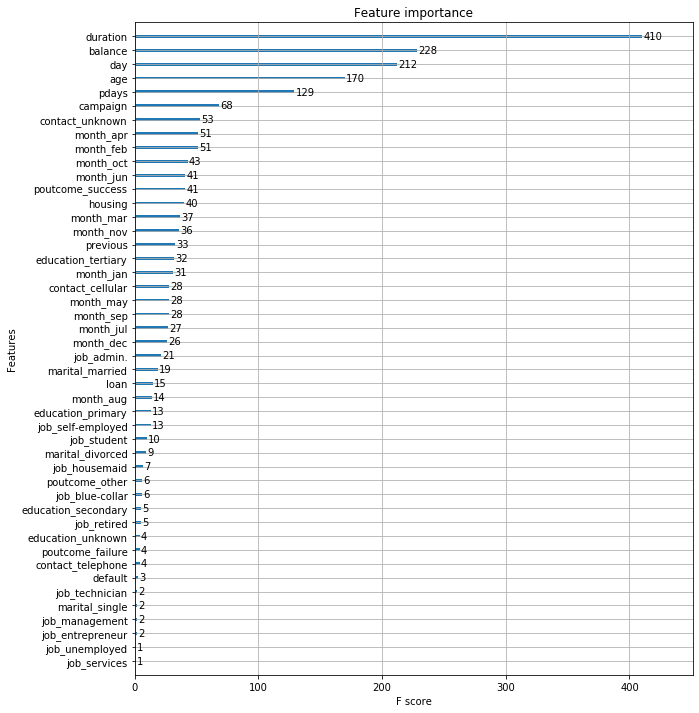

In [40]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)

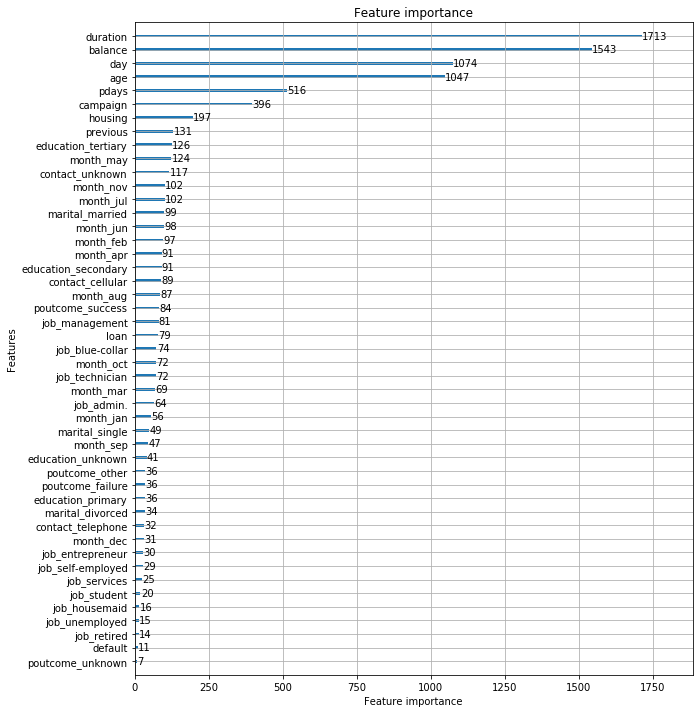

In [41]:
from lightgbm import plot_importance

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgb_model, ax=ax)

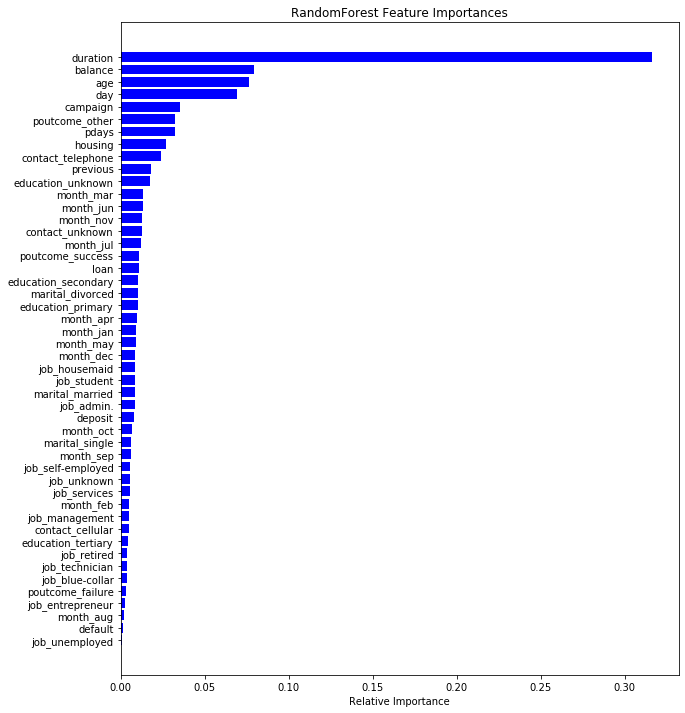

In [42]:
features = df2.columns
importances = forest_model.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(10, 12))
plt.title('RandomForest Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [43]:
forest_model.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)>

## (2) GridSearch
 *     'n_estimators':[300],
 *   'max_depth' : [6, 8, 10, 12], 
 *   'min_samples_leaf' : [8, 12, 18 ],
 *   'min_samples_split' : [8, 16, 20]

In [44]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[300],
    'max_depth' : [6, 8, 10, 12], 
    'min_samples_leaf' : [8, 12, 18],
    'min_samples_split' : [8, 16, 20]
}
# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf , param_grid=params , cv=2, n_jobs=-1 )
grid_cv.fit(X_train , y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 12, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 300}
최고 예측 정확도: 0.8386


In [45]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer # 평가지표
param_list = {"n_estimators": list(range(300, 500, 10)),
              "max_depth": [8, 12, 16, 20],
              "min_samples_split": [2, 4, 6, 8]}

rf_model = RandomForestClassifier()

rf_random_search = RandomizedSearchCV(
        estimator=rf_model,
        param_distributions = param_list,
        n_iter = 10,
        cv = 2,
        scoring = make_scorer(accuracy_score))

rf_random_search.fit(X_train, y_train)


RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [46]:
rf_random_search.best_params_

{'n_estimators': 460, 'min_samples_split': 8, 'max_depth': 20}

In [47]:
test_scores = []
train_preds = rf_random_search.predict(X_train)
test_preds  = rf_random_search.predict(X_test)

test_scores.append(round(accuracy_score(y_test, test_preds), 1))

print(' 훈련 정확도: {0:.2}'.format(round(accuracy_score(y_train, train_preds), 1)), "\n",
      '시험 정확도: {0:.2}'.format(round(accuracy_score(y_test,  test_preds), 1)), )

 훈련 정확도: 1.0 
 시험 정확도: 0.9


## (3) Ensemble

In [48]:
from sklearn.ensemble import VotingClassifier

voting_model = VotingClassifier(estimators=[('forest',forest_model),\
                                            ('xgb',xgb_model)] , voting='soft' )

voting_model.fit(X_train , y_train)
pred = voting_model.predict(X_test)
accuracy = accuracy_score(y_test , pred)
print('VotingClassifier 정확도: {0:.4f}'.format(accuracy))

VotingClassifier 정확도: 0.8591
